<a href="https://colab.research.google.com/github/Moukthika1253/NaiveBayesClassifier-Rotten-Tomato-reviews/blob/main/NBC_Rotten_tomato_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries

In [484]:
import pandas as pd
from sklearn.model_selection import train_test_split
import string,re
import nltk
from nltk import word_tokenize
'''nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')'''
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import defaultdict
from nltk.stem import PorterStemmer
import math

In [407]:
rt_df=pd.read_csv('/content/rt_reviews.csv',encoding='latin-1')

# Splitting dataset into Train-50%, Dev-20%, Test-30%

In [408]:
X_train,X_remaining, y_train, y_remaining= train_test_split(rt_df['Review'],rt_df['Freshness'],train_size=0.5)
X_test, X_dev, y_test, y_dev = train_test_split(X_remaining,y_remaining,test_size=0.3)
train_set=pd.concat([X_train,y_train],axis=1).reset_index(drop=True)
dev_set=pd.concat([X_dev,y_dev],axis=1).reset_index(drop=True)
test_set=pd.concat([X_test,y_test],axis=1).reset_index(drop=True)
print(f"Train set size:  ",train_set.shape)
print(f"Dev set size:  ",dev_set.shape)
print(f"Test set size:  ",test_set.shape)

Train set size:   (240000, 2)
Dev set size:   (72000, 2)
Test set size:   (168000, 2)


In [409]:
train_set.head()

,Review,Freshness
0,At least it's not dreadfully dull.,rotten
1,A dog's breakfast that is supremely enjoyable...,rotten
2,"As far as date night movies go, you could do ...",fresh
3,"Damning, though perhaps not entirely in the w...",fresh
4,Reds is a richly textured drama that successf...,fresh


# Pre-processing

In [410]:
def preprocessing(review):
  stop_words=stopwords.words('english')
  word_lemmatizer=WordNetLemmatizer()
  tokenized_words=[(word) for word in word_tokenize(review)]
  words=[word.lower() for word in tokenized_words if word.lower() not in stop_words]
  for i in range(len(words)):
   words[i]=''.join([word for word in words[i] if word not in (string.punctuation)])
  no_emptywords=[word for word in words if word]
  no_extraspace=[re.sub(r'\s\s+', '',word) for word in no_emptywords]
  lemmatized_words=[word_lemmatizer.lemmatize(word) for word in no_extraspace]
  return lemmatized_words 
  

In [411]:
train_set['Review']=train_set['Review'].apply(preprocessing)
train_set.head()

,Review,Freshness
0,"[least, s, dreadfully, dull]",rotten
1,"[dog, s, breakfast, supremely, enjoyable, firs...",rotten
2,"[far, date, night, movie, go, could, far, wors...",fresh
3,"[damning, though, perhaps, entirely, way, inte...",fresh
4,"[red, richly, textured, drama, successfully, b...",fresh


**Calculating Total number of words in Vocab**

In [412]:
review_list=[]
for i,review in train_set['Review'].items():
  for word in review:
    review_list.append(word)
review_list=list(set(review_list))
tot_words=len(review_list)
print(f"total number of words in the list: {tot_words}")

total number of words in the list: 86696


In [452]:
pos_reviews=0
neg_reviews=0
num_pos_words=0
num_neg_words=0
pos_words=[]
neg_words=[]
word_dict=defaultdict(lambda:[0,0])
freshness=list(train_set['Freshness'])

# Calculating word frequencies for each word in fresh and rotten review

In [453]:
for i, review in enumerate(list(train_set['Review'])):
  if  freshness[i] == 'fresh':
    pos_reviews=pos_reviews+1
  else:
    neg_reviews=neg_reviews+1
  for word in (review):
    if freshness[i] == 'fresh':
      word_dict[word][1]+=1
      num_pos_words+=1
      pos_words.append(word)
    else:
      word_dict[word][0]+=1
      num_neg_words+=1
      neg_words.append(word)

In [415]:
(word_dict)

defaultdict(<function __main__.<lambda>()>,
            {'least': [1519, 1002],
             's': [47750, 51062],
             'dreadfully': [42, 0],
             'dull': [1434, 148],
             'dog': [517, 335],
             'breakfast': [43, 19],
             'supremely': [32, 88],
             'enjoyable': [257, 1223],
             'first': [2491, 2559],
             'hour': [1407, 840],
             'unfortunately': [1181, 112],
             'bad': [3466, 989],
             'time': [5271, 5524],
             'el': [82, 123],
             'royale': [14, 35],
             '141': [7, 1],
             'minute': [2106, 1011],
             'long': [2175, 1693],
             'far': [1853, 1680],
             'date': [307, 382],
             'night': [757, 626],
             'movie': [18978, 15270],
             'go': [2954, 2361],
             'could': [3520, 2586],
             'worse': [686, 196],
             'raunchy': [117, 108],
             'yet': [1697, 2230],
             'swe

# Probability calculation

**P(fresh) and P(rotten)**

In [416]:
prob_rotten=train_set['Freshness'].value_counts(normalize=True)['rotten']
prob_fresh=train_set['Freshness'].value_counts(normalize=True)['fresh']
print(f'P(fresh) = {prob_fresh} P(rotten) = {prob_rotten}')

P(fresh) = 0.499975 P(rotten) = 0.500025


**P(word)**

In [417]:
def word_alone_prob(word):
  return ((word_dict[word][1]/num_pos_words))+((word_dict[word][0]/num_neg_words))

In [418]:
word_alone_prob('buffay')

0.0

**P(word|fresh) and P(word|rotten)**

In [419]:
def word_prob(reviewType, word):
  if reviewType == 'fresh':
    return (word_dict[word][1]/num_pos_words)
  else:
    return (word_dict[word][0]/num_neg_words)
  

In [420]:
word_prob('fresh','buffay')

0.0

In [421]:
word_prob('rotten','buffay')

0.0

**P(fresh|review) and P(rotten|review)**

In [422]:
def withoutSmoothing_probability(reviewType, review):
  if reviewType == 'fresh':
    prob=math.log(pos_reviews/len(rt_df))
  else:
    prob=math.log(neg_reviews/len(rt_df))
  preprocessed_reviews=[]
  preprocessed_reviews=preprocessing(review)
  for word in preprocessed_reviews:
     prob=prob+word_prob(reviewType,word)
  return prob
    

# Class Prediction

In [423]:
def predict_class_withoutSmoothing(sentence):
 if withoutSmoothing_probability('fresh',sentence) > withoutSmoothing_probability('rotten',sentence):
   return "fresh"
 else:
    return "rotten"

# Dev and Test accuracy without Smoothing

In [424]:
correct_pred=0
incorrect_pred=0
freshness=list(dev_set['Freshness'])
for i, word in enumerate(list(dev_set['Review'])):
  if predict_class_withoutSmoothing(word) == freshness[i]:
    correct_pred+=1
  else:
    incorrect_pred+=1

In [425]:
print("Accuracy on Dev dataset: ",correct_pred/(correct_pred+incorrect_pred))

Accuracy on Dev dataset:  0.6435416666666667


In [470]:
correct_pred=0
incorrect_pred=0
freshness=list(test_set['Freshness'])
for i, word in enumerate(list(test_set['Review'])):
  if predict_class_withoutSmoothing(word) == freshness[i]:
    correct_pred+=1
  else:
    incorrect_pred+=1

In [471]:
print("Accuracy on Test dataset: ",correct_pred/(correct_pred+incorrect_pred))

Accuracy on Test dataset:  0.6428273809523809


# Experiments

# Applied Smoothing

**P(word)**

In [428]:
alpha=1
def word_only_prob(word,num_words):
  return (math.log((word_dict[word][1]+alpha)/(num_pos_words+num_words)))+(math.log((word_dict[word][0]+alpha)/(num_neg_words+num_words)))

In [429]:
word_only_prob('buffay',tot_words)

-28.600141668202728

**P(fresh|word) and P(rotten|word)**

In [430]:
def cond_prob(reviewType, word,num_words):
  if reviewType == 'fresh':
    return math.log((word_dict[word][1]+alpha)/(num_pos_words+(num_words)))
  else:
    return math.log((word_dict[word][0]+alpha)/(num_neg_words+(num_words)))

In [431]:
cond_prob('fresh','buffay',tot_words)

-14.313597386722039

**P(fresh|review) and P(rotten|review)**

In [432]:
def review_probability(reviewType, review,n):
  if reviewType == 'fresh':
    prob=math.log(pos_reviews/len(rt_df))
  else:
    prob=math.log(neg_reviews/len(rt_df))
  preprocessed_reviews=[]
  preprocessed_reviews=preprocessing(review)
  for word in preprocessed_reviews:
     prob=prob+cond_prob(reviewType,word,n)
  return prob
    

**Comparing probabilities of fresh and rotten class**

In [433]:
print(review_probability('fresh','Story inspired by historical events that illustrates the process whereby enemies can become friends..',tot_words))
print(review_probability('rotten','Story inspired by historical events that illustrates the process whereby enemies can become friends.',tot_words))

-89.62085500247909
-91.80334870788207


**Class prediction**

In [434]:
def predict_class(sentence,n):
 if review_probability('fresh',sentence,n) > review_probability('rotten',sentence,n):
   return "fresh"
 else:
    return "rotten"

In [435]:
predict_class('Story inspired by historical events that illustrates the process whereby enemies can become friends.',tot_words)

'fresh'

# Deriving top 10 words that predict each class

In [436]:
def topmost_prob(pos_word):
  p={}
  for i in range(len(pos_word)):
   num=(cond_prob('fresh',pos_word[i],tot_words))
   p[pos_word[i]]=num
  return p

In [437]:
def topmost_negprob(neg_word):
  p={}
  for i in range(len(neg_word)):
   num=(cond_prob('rotten',neg_word[i],tot_words))
   p[neg_word[i]]=num
  return p

**Top 10 words that predict class=Fresh**

In [438]:
p=topmost_prob(pos_words)
top10_words=sorted(p.items(),key=lambda x:x[1],reverse=True)
print("Top 10 words         P[class='fresh'|word]")
for i, (k,v) in enumerate(top10_words[:10]):
 print(k,"                    ", v)


Top 10 words         P[class='fresh'|word]
s                      -3.4727819432459563
film                      -4.217260555505302
movie                      -4.679886502768857
one                      -5.0202034596105705
nt                      -5.075544576179321
story                      -5.376247538454647
like                      -5.418104755270407
make                      -5.47403088306409
performance                      -5.610090617242309
time                      -5.6965588603360855


**Top 10 words that predict class=Rotten**

In [439]:
p=topmost_negprob(neg_words)
top10_words=sorted(p.items(),key=lambda x:x[1],reverse=True)
print("Top 10 words         P[class='rotten'|word]")
for i, (k,v) in enumerate(top10_words[:10]):
 print(k,"                    ", v)

Top 10 words         P[class='rotten'|word]
s                      -3.512788993382724
film                      -4.401271617365465
movie                      -4.435455897743768
nt                      -4.543166797373296
like                      -5.027985337234031
one                      -5.178236635069657
much                      -5.464222104008949
story                      -5.467322423905748
make                      -5.498103324076094
character                      -5.553433583841981


 **Accuracy on dev dataset**

In [440]:
correct_pred=0
incorrect_pred=0
freshness=list(dev_set['Freshness'])
for i, word in enumerate(list(dev_set['Review'])):
  if predict_class(word,tot_words) == freshness[i]:
    correct_pred+=1
  else:
    incorrect_pred+=1

In [441]:
print("Accuracy on Dev dataset: ",correct_pred/(correct_pred+incorrect_pred))

Accuracy on Dev dataset:  0.7983472222222222


**Testing on Test dataset**

In [442]:
correct_pred=0
incorrect_pred=0
freshness=list(test_set['Freshness'])
for i, word in enumerate(list(test_set['Review'])):
  if predict_class(word,tot_words) == freshness[i]:
    correct_pred+=1
  else:
    incorrect_pred+=1

In [443]:
print("Accuracy on Test dataset: ",correct_pred/(correct_pred+incorrect_pred))

Accuracy on Test dataset:  0.7973630952380952


# After removing rare words (occurence<5)

In [454]:
word_dict_copy=word_dict.copy()
count=0
for i, (k,v) in enumerate(word_dict_copy.items()):
  if (v[0]<5 and v[1]<5):
    del(k)
    count+=1

In [455]:
print(f"Total number of rare words: {count}")
no_rarewords=tot_words-count

Total number of rare words: 61430


In [456]:
print(f'Total number of words after removing rarewords: {no_rarewords}')

Total number of words after removing rarewords: 25266


**Accuracy on dev dataset**

In [457]:
correct_pred=0
incorrect_pred=0
freshness=list(dev_set['Freshness'])
for i, word in enumerate(list(dev_set['Review'])):
  if predict_class(word,no_rarewords) == freshness[i]:
    correct_pred+=1
  else:
    incorrect_pred+=1

In [458]:
print("Accuracy on Dev dataset: ",correct_pred/(correct_pred+incorrect_pred))

Accuracy on Dev dataset:  0.7982916666666666


**Accuracy on Test dataset**

In [459]:
correct_pred=0
incorrect_pred=0
freshness=list(test_set['Freshness'])
for i, word in enumerate(list(test_set['Review'])):
  if predict_class(word,no_rarewords) == freshness[i]:
    correct_pred+=1
  else:
    incorrect_pred+=1

In [460]:
print("Accuracy on Test dataset: ",correct_pred/(correct_pred+incorrect_pred))

Accuracy on Test dataset:  0.7972916666666666


# Considering small dataset where total number of words=15000

**Selecting first 15000 most frequent occuring words from vocabulary**

In [461]:
word_dict = sorted(word_dict.items(),  key=lambda x : x[1][0] + x[1][1], reverse=True)[:15000]

In [462]:
word_dict = defaultdict(lambda: [0, 0], word_dict)

**Dev Accuracy**

In [463]:
correct_pred=0
incorrect_pred=0
freshness=list(dev_set['Freshness'])
for i, word in enumerate(list(dev_set['Review'])):
  if predict_class(word,15000) == freshness[i]:
    correct_pred+=1
  else:
    incorrect_pred+=1

In [464]:
print("Accuracy on Dev dataset: ",correct_pred/(correct_pred+incorrect_pred))

Accuracy on Dev dataset:  0.7862083333333333


**Test ACcuracy**

In [468]:
correct_pred=0
incorrect_pred=0
freshness=list(test_set['Freshness'])
for i, word in enumerate(list(test_set['Review'])):
  if predict_class(word,15000) == freshness[i]:
    correct_pred+=1
  else:
    incorrect_pred+=1

In [469]:
print("Accuracy on Test dataset: ",correct_pred/(correct_pred+incorrect_pred))

Accuracy on Test dataset:  0.7847321428571429


# Comparing Dev and Test accuracies across different models

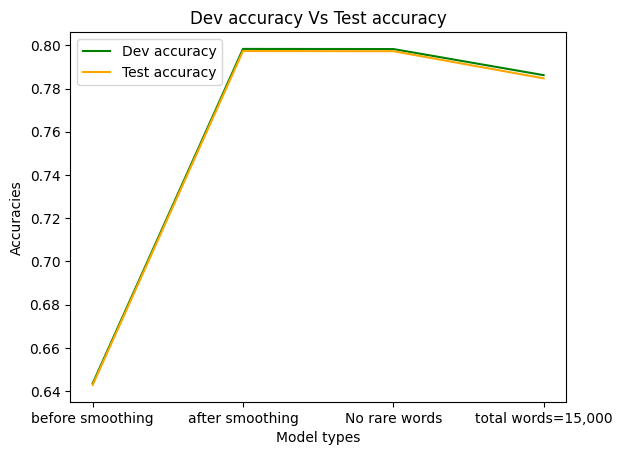

In [483]:
accuracies_dev=[0.6435416666666667,0.7983472222222222,0.7982916666666666,0.7862083333333333]
accuracies_test=[0.6428273809523809,0.7973630952380952,0.7972916666666666,0.7847321428571429]
types=["before smoothing","after smoothing","No rare words","total words=15,000"]
import matplotlib.pyplot as plt
plt.title("Dev accuracy Vs Test accuracy")
plt.plot(types,accuracies_dev,'g',label="Dev accuracy")
plt.plot(types,accuracies_test,'orange',label="Test accuracy")
plt.xlabel('Model types')
plt.ylabel('Accuracies')
plt.legend()
plt.show()